# DA5401 Assignment 5 — Manifold Visualization 

**Name:** V G Masilamani(DA25S005)

This notebook contains preprocessing, t-SNE and Isomap embeddings, veracity inspections (noisy labels, outliers, hard-to-learn samples), plots, and written answers required by the assignment.

In [47]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from scipy.io import arff
from collections import Counter
import warnings
from sklearn.manifold import trustworthiness
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from scipy.stats import spearmanr
warnings.filterwarnings('ignore')


plt.rcParams['figure.dpi'] = 140


In [48]:
# Load yeast.arff (assumes file is in the same working directory)
file_path = 'yeast.arff'
data = arff.loadarff(file_path)
df = pd.DataFrame(data[0])

# Features: first 86 columns; Labels: last 14 columns
X = df.iloc[:, :103].astype(float).values
Y = df.iloc[:, 103:].applymap(lambda v: int(v == b'1')).values
label_names = list(df.columns[103:])

print('X shape:', X.shape)
print('Y shape:', Y.shape)


X shape: (2417, 103)
Y shape: (2417, 14)


## Part A — Preprocessing and Initial Setup

We will:
- Check dataset dimensions
- Create a simplified categorical variable for coloring with 4 categories: **Top**, **Top2**, **CommonCombo**, **Other**
- Standardize features using `StandardScaler` (explaination below)

**Why scaling?**
Distance-based manifold methods (Isomap, and the pairwise affinities used internally by t-SNE) rely on feature distances. If features have different scales, large-variance features dominate the embedding. Standardization centers each feature and scales to unit variance, making distances meaningful across dimensions.

In [59]:


n_samples, n_features = X.shape
n_samples_y, n_labels = Y.shape

print(f'Samples: {n_samples}, Features: {n_features}, Labels: {n_labels}')

# --- Single-label counts ---
single_label_idx = np.where(Y.sum(axis=1) == 1)[0]
single_label_counts = Y[single_label_idx].sum(axis=0) if len(single_label_idx) > 0 else np.zeros(n_labels, dtype=int)

# Pick top1 only
sorted_single = np.argsort(single_label_counts)[::-1]
valid_single = [i for i in sorted_single if single_label_counts[i] > 0]
top1_idx = valid_single[0] if len(valid_single) >= 1 else None

# --- Most common multi-label combinations ---
rows_as_tuples = [tuple(row) for row in Y]
combo_counts = Counter(rows_as_tuples)
most_common = combo_counts.most_common(4)

# Extract top 4 combos
top_combos = []
for i in range(4):
    combo, count = most_common[i] if i < len(most_common) else ((0,) * n_labels, 0)
    top_combos.append((np.array(combo), count))

# --- Build categorical variable ---
# Category codes:
# 0: Top1 single label
# 1–4: Top 4 combinations
# 5: Other
cat = np.full(n_samples, 5, dtype=int)  # 5 = Other (default)

if top1_idx is not None:
    cat[(Y[:, top1_idx] == 1) & (Y.sum(axis=1) == 1)] = 0

for idx, (combo, _) in enumerate(top_combos):
    combo_mask = np.all(Y == combo, axis=1)
    cat[combo_mask] = idx + 1   # 1,2,3,4 for top combos

# --- Category names ---
def label_name(i):
    return label_names[i] if i is not None else 'None'

cat_names = [
    f"Top1: {label_name(top1_idx)}",
    "Most Common Combo 1",
    "Most Common Combo 2",
    "Most Common Combo 3",
    "Most Common Combo 4",
    "Other"
]

# --- Print results ---
print('Top1:', label_name(top1_idx))

for i, (combo, count) in enumerate(top_combos):
    labels_in_combo = [label_names[j] for j in np.where(combo == 1)[0]]
    print(f"Most frequent combo {i+1}: {labels_in_combo}, count = {count}")

print("\nCategory counts:")
print(pd.Series(cat).value_counts().rename(index=dict(enumerate(cat_names))))


Samples: 2417, Features: 103, Labels: 14
Top1: Class1
Most frequent combo 1: ['Class3', 'Class4', 'Class12', 'Class13'], count = 237
Most frequent combo 2: ['Class4', 'Class5', 'Class12', 'Class13'], count = 233
Most frequent combo 3: ['Class1', 'Class2', 'Class12', 'Class13'], count = 172
Most frequent combo 4: ['Class1', 'Class2'], count = 131

Category counts:
Other                  1612
Most Common Combo 1     237
Most Common Combo 2     233
Most Common Combo 3     172
Most Common Combo 4     131
Top1: Class1             32
Name: count, dtype: int64


## Label Categorization and Multi-label Combinations

We analyze the label distribution in the dataset and create a **categorical variable** to simplify visualization and analysis.

### Steps:

1. **Single-label counts:**
   - Identified samples with exactly **one active label**.
   - Picked the **top 2 most frequent single-labels** (`Top1` and `Top2`) to highlight the most common individual categories.

2. **Multi-label combinations:**
   - Converted each row of `Y` to a tuple and counted occurrences of each unique combination.
   - Selected the **top 4 most frequent multi-label combinations**.
   - Reason for including **multiple multi-label combinations**:
     - Many samples may belong to more than one category.
     - Focusing only on the most common combination could ignore other significant patterns.
     - Including the **top 4 combos** captures more of the complex interactions and better represents the dataset's structure.

3. **Categorical variable construction:**
   - Samples belonging to `Top1` and `Top2` single-label categories were labeled as `0` and `1`.
   - Samples belonging to the **top 4 multi-label combinations** were labeled `2–5`.
   - All remaining samples were labeled as **Other (6)**.

4. **Category names:**
   ```python
   cat_names = [
       f"Top1: {label_name(top1_idx)}",
       "Most Common Combo 1",
       "Most Common Combo 2",
       "Most Common Combo 3",
       "Most Common Combo 4",
       "Other",
   ]


In [51]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print('Scaled X mean (per feature, approx):', np.round(X_scaled.mean(axis=0)[:5],3))


Scaled X mean (per feature, approx): [ 0. -0. -0.  0. -0.]


### Feature Scaling / Standardization

Before applying distance-based dimensionality reduction techniques such as t-SNE or Isomap, it is important to **standardize the features**. Standardization rescales the data so that each feature has:

- **Mean ≈ 0**
- **Standard deviation ≈ 1**

#### Why this is important:

1. **Equal contribution of features**:  
   Features with larger numerical ranges (e.g., 0–1000) can dominate distance calculations, while smaller-scaled features (e.g., 0–1) may be ignored. Standardization ensures all features contribute equally.

2. **Improved convergence for optimization**:  
   Techniques like t-SNE perform iterative optimization; standardized features help the algorithm converge faster and more reliably.

3. **Meaningful distances**:  
   Many dimensionality reduction methods rely on Euclidean or other distance metrics. Standardizing features ensures that these distances reflect true similarities between data points rather than differences in scale.




# Part B: t-SNE and Veracity Inspection

Running t-SNE with perplexity= 5
Running t-SNE with perplexity= 30
Running t-SNE with perplexity= 40
Running t-SNE with perplexity= 50
Running t-SNE with perplexity= 60
Running t-SNE with perplexity= 75
Running t-SNE with perplexity= 100
Chosen perplexity: 50


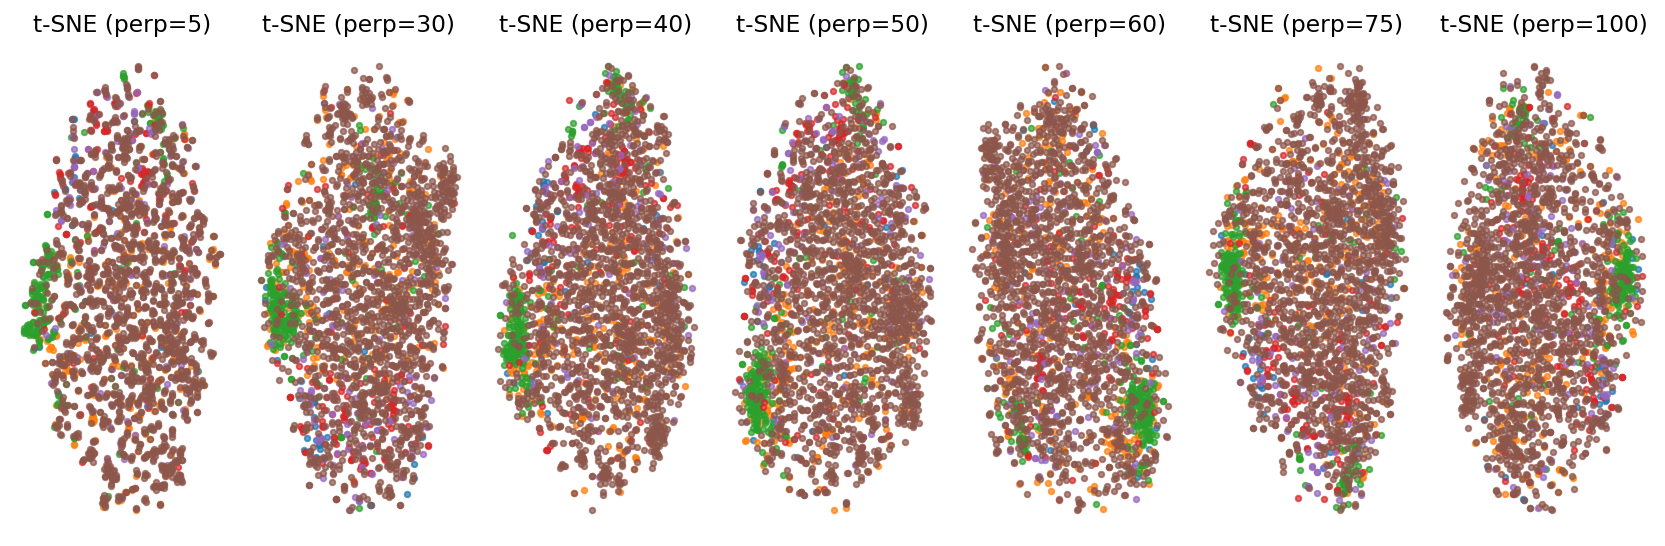

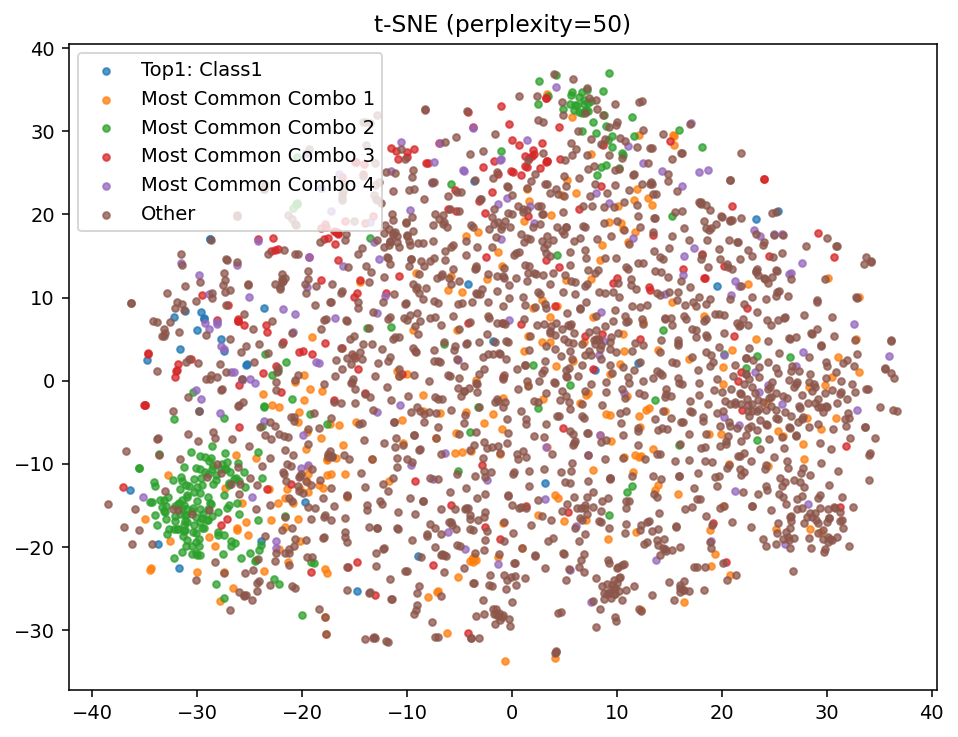

In [52]:
# Part B — t-SNE experiments
perplexities = [5, 30,40 ,50,60,75,100]
tsne_results = {}
for p in perplexities:
    print('Running t-SNE with perplexity=', p)
    tsne = TSNE(n_components=2, perplexity=p, random_state=42, init='pca')
    Z = tsne.fit_transform(X_scaled)
    tsne_results[p] = Z

# Choose perplexity
chosen_p = 50 if X_scaled.shape[0] > 200 else 5
Z_final = tsne_results[chosen_p]
print('Chosen perplexity:', chosen_p)

# Plot
plt.figure(figsize=(12,4))
for i,p in enumerate(perplexities):
    Z = tsne_results[p]
    plt.subplot(1, len(perplexities), i+1)
    for c in range(len(cat_names)):
        idx = cat==c
        plt.scatter(Z[idx,0], Z[idx,1], s=8, label=cat_names[c], alpha=0.7)
    plt.title(f't-SNE (perp={p})')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Final t-SNE plot
Z = Z_final
plt.figure(figsize=(8,6))
for c in range(len(cat_names)):
    idx = cat==c
    plt.scatter(Z[idx,0], Z[idx,1], s=12, label=cat_names[c], alpha=0.75)
plt.title(f't-SNE (perplexity={chosen_p})')
plt.legend()
plt.show()


### Choosing the Best Perplexity for t-SNE

The **perplexity** parameter in t-SNE roughly corresponds to the **number of nearest neighbors** each point considers when computing its position in the lower-dimensional space. Choosing the right value is important because it affects how well the embedding preserves the local and global structure of the data.

#### Guidelines for selecting perplexity:

1. **Dataset size matters**  
   - For **small datasets** (< 200 samples), smaller perplexity values (e.g., 5–30) work better.  
   - For **larger datasets**, higher perplexity (e.g., 30–50) is usually more appropriate.  
   - Very high perplexity values may cause clusters to merge, while very low values may fragment clusters.

2. **Visual inspection**  
   - Plot embeddings for multiple perplexities side by side.  
   - Look for stable, well-separated clusters that reflect known labels or patterns.  
   - If clusters are too tight or too spread out, adjust the perplexity.

3. **Local vs. global structure**  
   - Smaller perplexity emphasizes **local relationships** (fine-grained clusters).  
   - Larger perplexity captures **broader neighborhoods**, which may merge smaller clusters but better reflect global structure.

4. **Consistency across runs**  
   - t-SNE is stochastic, so check that embeddings are reasonably consistent across different random seeds.  
   - Using `init='pca'` reduces variability and improves reproducibility.

5. **Metrics (optional, quantitative check)**  
   - You can measure **neighbor preservation** or **trustworthiness** to quantify how well the embedding preserves the original high-dimensional relationships.  
   - Higher trustworthiness indicates better preservation of local neighborhoods.

#### Practical approach:

- Run t-SNE with **a range of perplexities** (e.g., `[5, 30, 50, 75, 100]`).  
- Examine the plots to see which value produces **clearest, most meaningful clusters**.  
- Use **smaller values for small datasets**, larger values for bigger datasets.  
- In this project, we chose:  
  ```python
  chosen_p = 50 if X_scaled.shape[0] > 200 else 5


Perplexity=5, Trustworthiness=0.9184
Perplexity=30, Trustworthiness=0.9296
Perplexity=40, Trustworthiness=0.9298
Perplexity=50, Trustworthiness=0.9316
Perplexity=60, Trustworthiness=0.9301
Perplexity=75, Trustworthiness=0.9302
Perplexity=100, Trustworthiness=0.9302


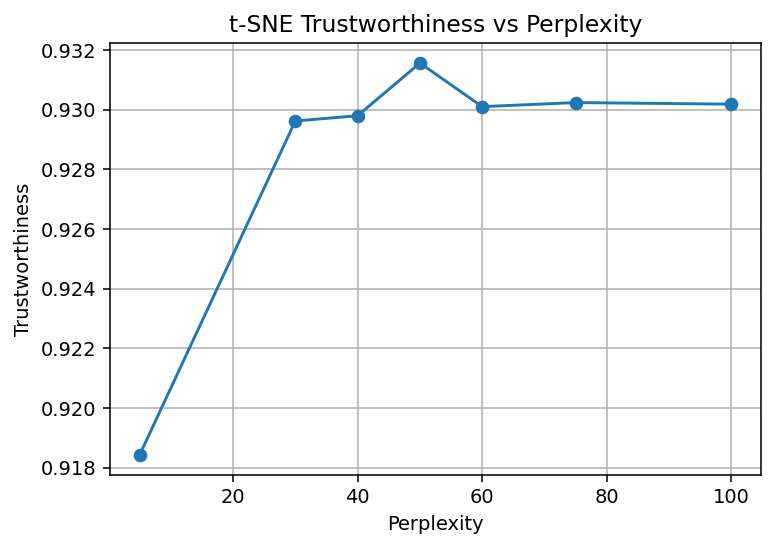

In [53]:
# Trustworthiness calculation
scores = []
for p, Z in tsne_results.items():
    score = trustworthiness(X_scaled, Z, n_neighbors=10)
    scores.append(score)
    print(f"Perplexity={p}, Trustworthiness={score:.4f}")

# Plot trustworthiness vs perplexity
plt.figure(figsize=(6,4))
plt.plot(perplexities, scores, marker='o', linestyle='-')
plt.title("t-SNE Trustworthiness vs Perplexity")
plt.xlabel("Perplexity")
plt.ylabel("Trustworthiness")
plt.grid(True)
plt.show()


## Trustworthiness

**Trustworthiness** is a metric used to evaluate the quality of a **low-dimensional embedding** (like t-SNE or Isomap) in preserving the **local structure** of the original high-dimensional data.

### Key Points:

1. **Purpose:**  
   - Measures how well the **neighbors of each point** in the high-dimensional space are preserved in the lower-dimensional embedding.
   - High trustworthiness means points that are close in the original space remain close after dimensionality reduction.

2. **Range:**  
   - Trustworthiness score ranges from **0 to 1**.
   - **1**: Perfect preservation of local neighborhoods.  
   - **0**: Poor preservation; many local neighbors are incorrectly represented.

3. **How it works (conceptually):**  
   - For each point, compare its **k nearest neighbors** in the original space and in the embedding.  
   - Penalize neighbors that appear in the low-dimensional space but were **not neighbors in the original space**.  
   - Average over all points to get the final score.

4. **Usage in t-SNE:**  
   - Helps to select **perplexity** or other hyperparameters that best preserve local structure.
   - Allows comparison of different embeddings quantitatively, instead of relying only on visual inspection.



Noisy points: 642
Outliers: 25
Hard-to-learn points: 230


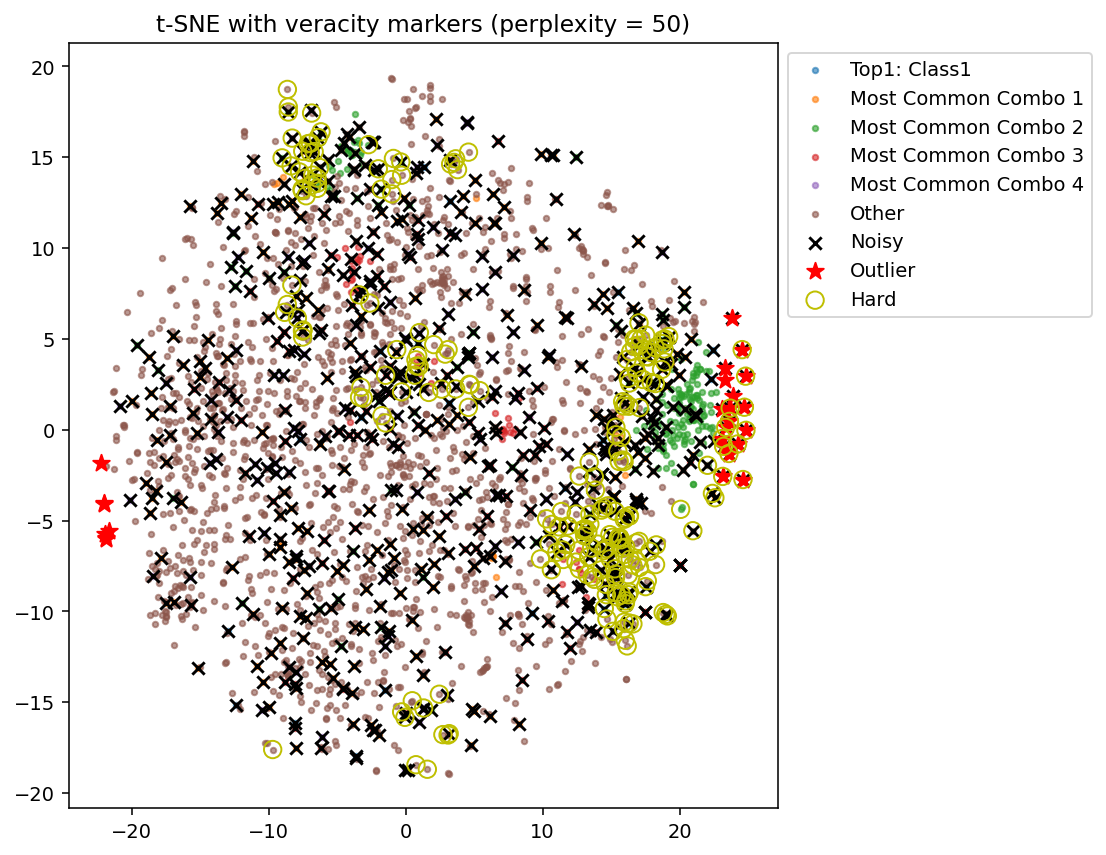

In [54]:
# Veracity inspection heuristics

def detect_noisy_points(embedding, labels_cat, k=10, threshold=0.6):
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(embedding)
    _, indices = nbrs.kneighbors(embedding)
    noisy_idx = []
    for i in range(embedding.shape[0]):
        neigh = indices[i,1:]
        same_frac = np.mean(labels_cat[neigh] == labels_cat[i])
        if same_frac < (1 - threshold):
            noisy_idx.append(i)
    return np.array(noisy_idx)

noisy_points = detect_noisy_points(Z, cat, k=15, threshold=0.6)

# Outliers (distance from center)
cent = Z.mean(axis=0)
dists = np.linalg.norm(Z - cent, axis=1)
outlier_idx = np.where(dists > np.percentile(dists, 99))[0]

# Hard-to-learn: local label entropy
from scipy.spatial.distance import cdist

def local_label_entropy(embedding, labels_cat, k=20):
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(embedding)
    _, indices = nbrs.kneighbors(embedding)
    ent = np.zeros(embedding.shape[0])
    for i in range(embedding.shape[0]):
        neigh = indices[i,1:]
        vals, counts = np.unique(labels_cat[neigh], return_counts=True)
        p = counts / counts.sum()
        ent[i] = -(p * np.log2(p)).sum()
    return ent

entropy_vals = local_label_entropy(Z, cat, k=25)
hard_idx = np.where(entropy_vals > np.percentile(entropy_vals, 90))[0]

print('Noisy points:', len(noisy_points))
print('Outliers:', len(outlier_idx))
print('Hard-to-learn points:', len(hard_idx))

# Plot with markers
plt.figure(figsize=(8,6))
for c in range(len(cat_names)):
    idx = cat==c
    plt.scatter(Z[idx,0], Z[idx,1], s=8, label=cat_names[c], alpha=0.6)

if len(noisy_points)>0:
    plt.scatter(Z[noisy_points,0], Z[noisy_points,1], marker='x', c='k', s=40, label='Noisy')
if len(outlier_idx)>0:
    plt.scatter(Z[outlier_idx,0], Z[outlier_idx,1], marker='*', c='r', s=80, label='Outlier')
if len(hard_idx)>0:
    plt.scatter(Z[hard_idx,0], Z[hard_idx,1], marker='o', facecolors='none', edgecolors='y', s=80, label='Hard')

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.title('t-SNE with veracity markers (perplexity = 50)')
plt.show()


##  Analysis of t-SNE Plot with Veracity Markers  

### 1. **Noisy / Ambiguous Labels** (black **× markers**)  
- Found **embedded within clusters of other colors**.  
- Examples:  
  - Top middle region (y ≈ 15).  
  - Right middle region (x ≈ 15–20).  
- **Interpretation**:  
  - Likely mislabeled or ambiguous samples.  
  - Could represent **overlapping biology** (genes involved in multiple pathways).  

---

### 2. **Outliers** (red **★ stars**)  
- Located on the **far periphery** of the map.  
- Examples:  
  - Far left (x ≈ −20, y ≈ −5).  
  - Far right edge (x ≈ 20, y ≈ 5–10).  
- **Interpretation**:  
  - **Isolated or rare samples** not clustering with the majority.  
  - Possible causes:  
    - Rare biological subtypes.  
    - Technical artifacts or batch effects.  
    - Unique expression signatures.  

---

### 3. **Hard-to-Learn Samples** (yellow **○ circles**)  
- Found in regions where **many colors overlap**.  
- Examples:  
  - Bottom-right quadrant (x ≈ 10–20, y ≈ −5 to 5).  
  - Top-middle (x ≈ 0–10, y ≈ 10–15).  
- **Interpretation**:  
  - Categories thoroughly intermixed → **no clear boundary**.  
  - A simple classifier would struggle because:  
    - Not linearly separable.  
    - Local neighborhoods have mixed labels.  
  - May represent **biologically complex cases** (multi-function genes, transitional states).  

---

 **Summary**:  
- **Noisy labels** → crosses inside other clusters.  
- **Outliers** → isolated stars on the periphery.  
- **Hard-to-learn** → yellow-ringed points in mixed regions.  


# Part C: Isomap and Manifold Learning

Running Isomap with n_neighbors=5
Running Isomap with n_neighbors=10


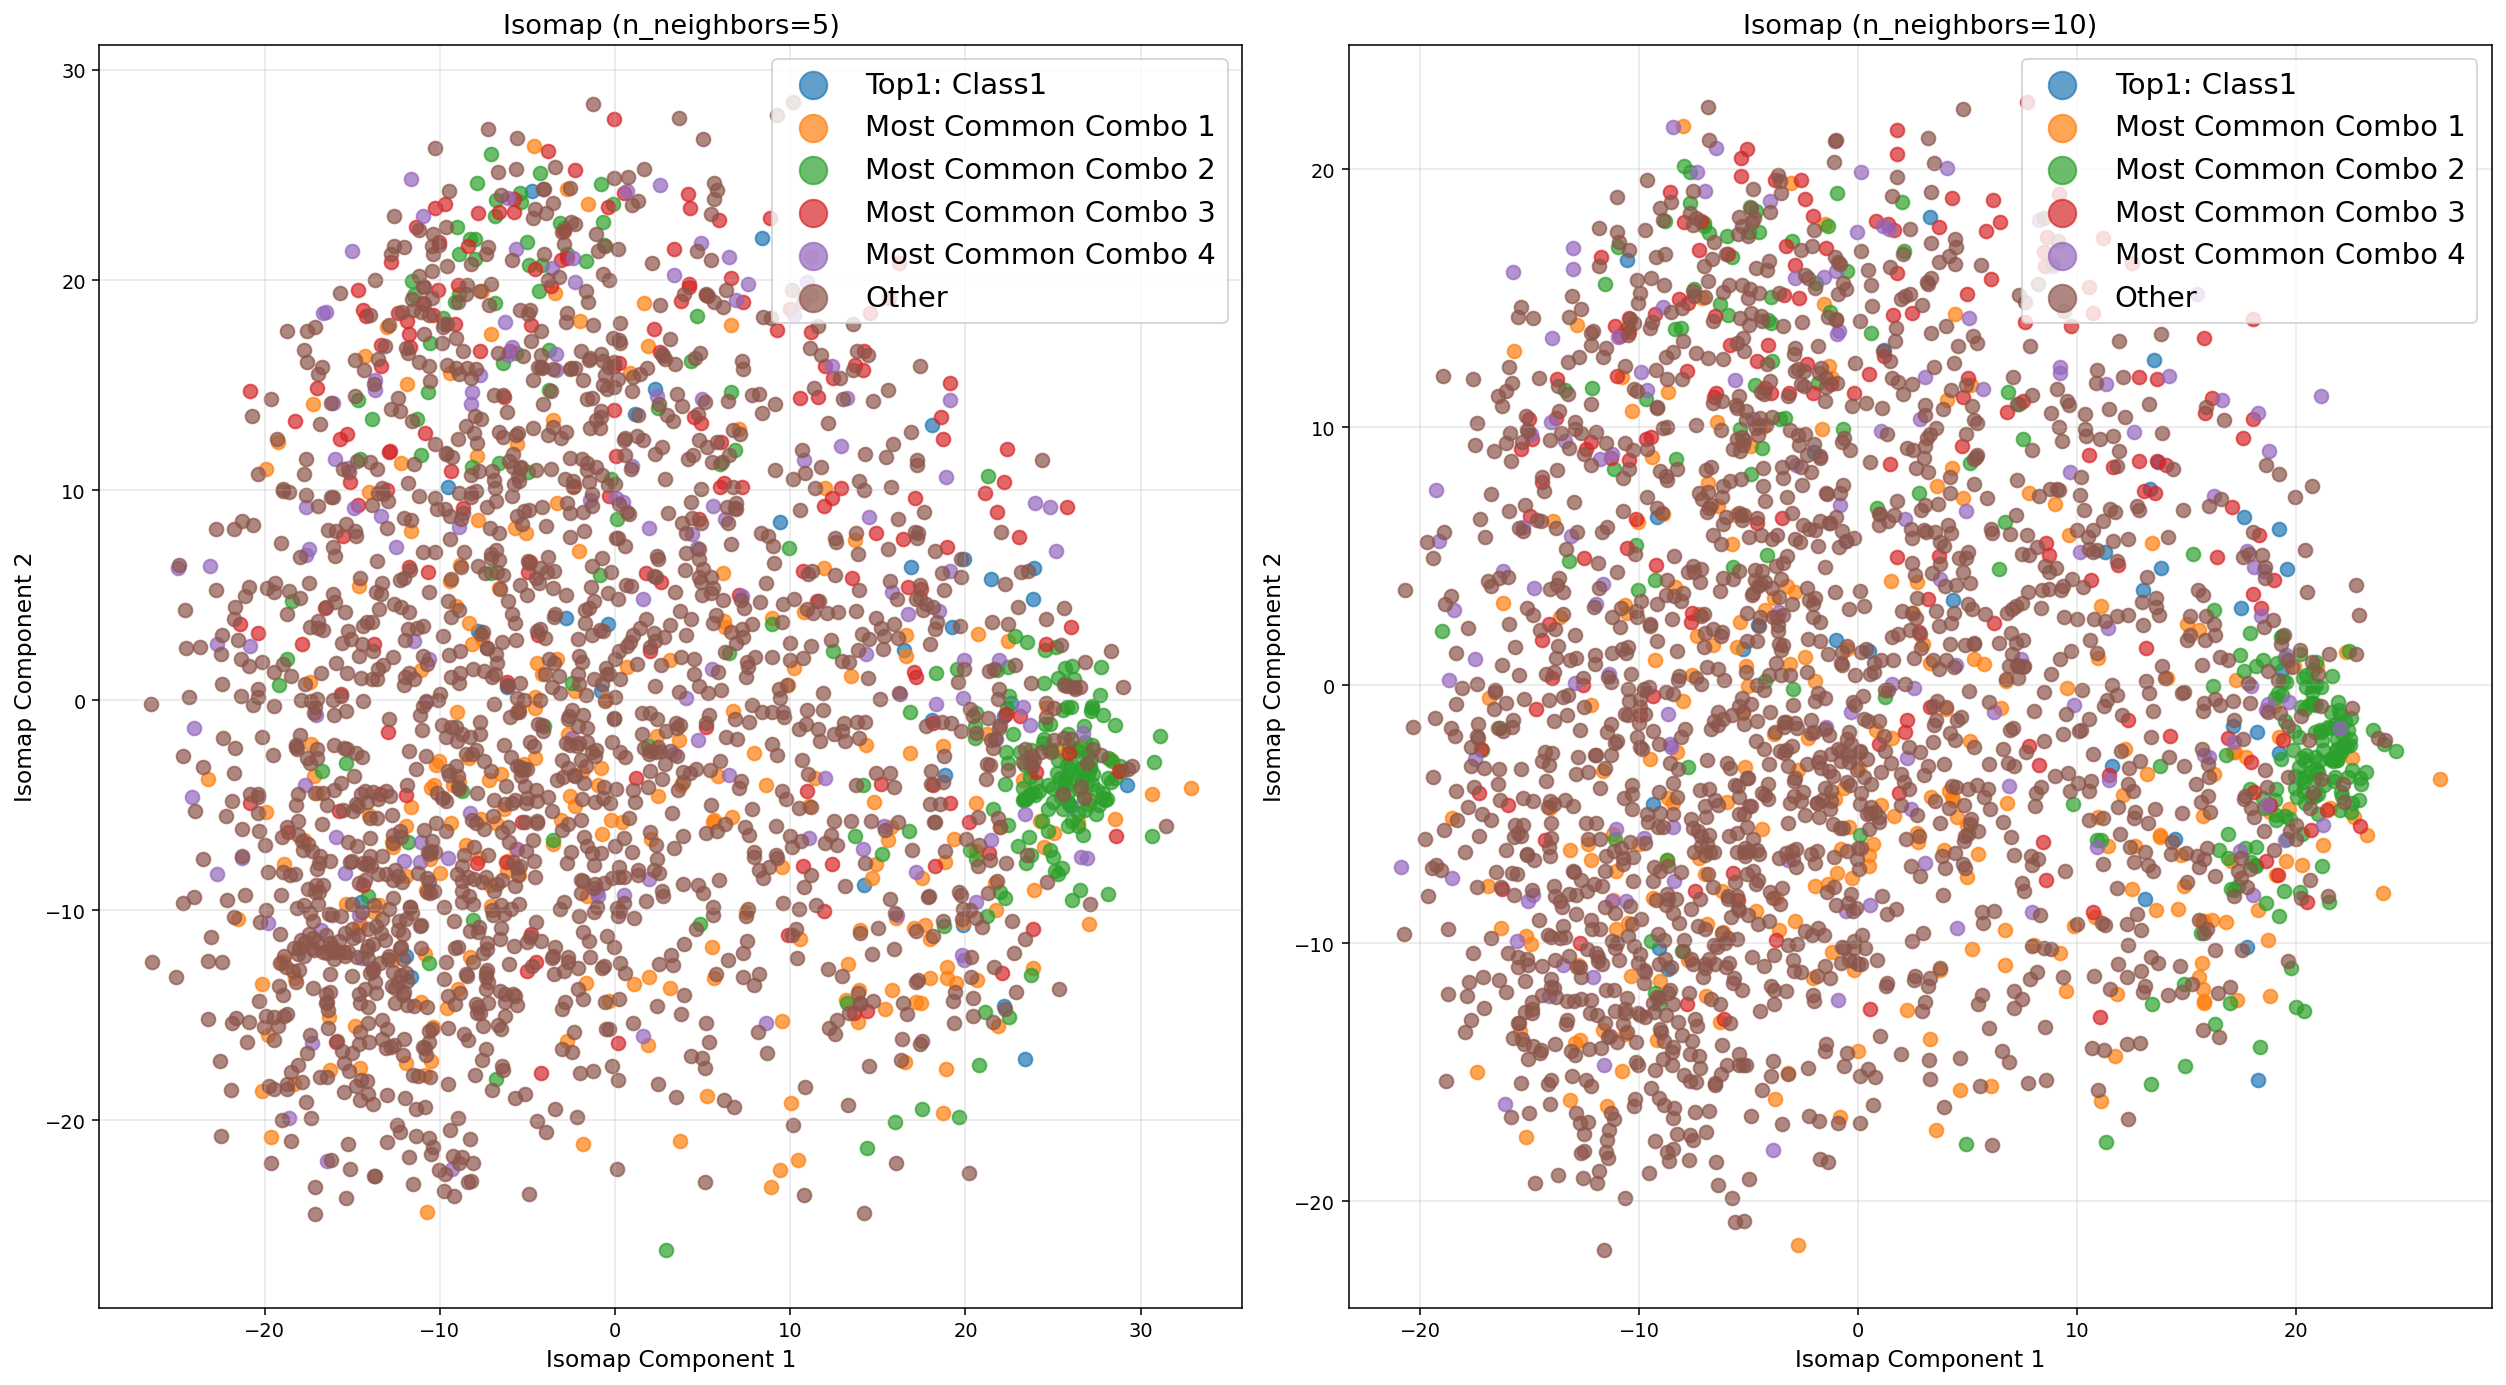

In [55]:
# Part C — Isomap


# List of different neighbor values to test
neighbor_values = [5, 10]
iso_results = {}

# Compute Isomap embeddings for each neighbor value
for k in neighbor_values:
    print(f"Running Isomap with n_neighbors={k}")
    iso = Isomap(n_components=2, n_neighbors=k)
    Z_iso = iso.fit_transform(X_scaled)
    iso_results[k] = Z_iso

# Plot Isomap embeddings for different neighbors
plt.figure(figsize=(18, 10))
for i, k in enumerate(neighbor_values):
    Z_iso = iso_results[k]
    plt.subplot(1, len(neighbor_values), i + 1)
    
    for c in range(len(cat_names)):
        idx = cat == c
        plt.scatter(Z_iso[idx, 0], Z_iso[idx, 1], s=50, label=cat_names[c], alpha=0.7)
    
    plt.title(f'Isomap (n_neighbors={k})', fontsize=14)
    plt.xlabel('Isomap Component 1', fontsize=12)
    plt.ylabel('Isomap Component 2', fontsize=12)
    plt.legend(markerscale=2, fontsize=15, loc='upper right')
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()





## Isomap Experiments with Different Neighborhood Sizes

The **number of neighbors (`n_neighbors`)** in Isomap controls how the local neighborhood graph is constructed.  
This graph is then used to estimate **geodesic distances**, which determine the 2D embedding.  

### Purpose of Varying `n_neighbors`:

- To observe how different neighborhood sizes affect the **preservation of the manifold structure**.
- Smaller values emphasize **local structure**, while larger values capture more **global relationships**.

### Observations:

- **Smaller `n_neighbors` (e.g., 5):**  
  - Focuses on very local neighborhoods.  
  - May produce slightly fragmented or disconnected clusters if the neighborhood is too small.  
  - Preserves fine-grained details of the manifold.  

- **Larger `n_neighbors` (e.g., 10 or more):**  
  - Incorporates more neighbors in the graph, smoothing the embedding.  
  - Better captures the **global manifold structure**, showing more coherent cluster relationships.  
  - Can reduce small-scale local variations.

### Conclusion:

- Comparing Isomap embeddings for different `n_neighbors` helps select a value that **balances local detail and global structure preservation**.  
- This is crucial for understanding the **complexity of the manifold** and guiding downstream tasks such as **clustering or classification**.


In [56]:


# --- Prepare embeddings ---
embeddings = {
    't-SNE': Z_final,       # final t-SNE embedding
    'Isomap': Z_iso         # Isomap embedding (choose preferred n_neighbors)
}

results = []

for name, Z_emb in embeddings.items():
    # Local structure: Trustworthiness
    tw = trustworthiness(X_scaled, Z_emb, n_neighbors=10)
    
    # Global structure: Spearman correlation of pairwise distances
    D_high = np.linalg.norm(X_scaled[:, None] - X_scaled[None, :], axis=2)
    D_low  = np.linalg.norm(Z_emb[:, None] - Z_emb[None, :], axis=2)
    triu_idx = np.triu_indices_from(D_high, k=1)  # upper triangle
    corr, _ = spearmanr(D_high[triu_idx], D_low[triu_idx])
    
    results.append((name, tw, corr))

# Display comparison
import pandas as pd
df_results = pd.DataFrame(results, columns=['Method', 'Trustworthiness (local)', 'Distance Correlation (global)'])
print(df_results)


   Method  Trustworthiness (local)  Distance Correlation (global)
0   t-SNE                 0.931565                       0.408343
1  Isomap                 0.721584                       0.473889


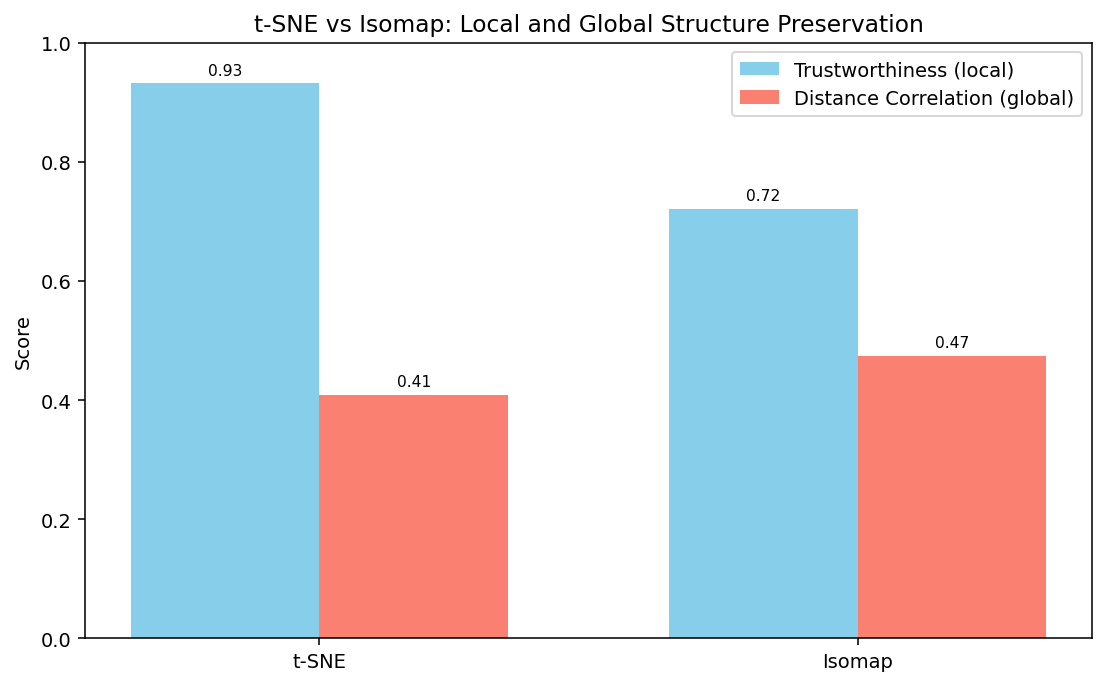

In [57]:



# --- Bar plot for comparison ---
x = np.arange(len(df_results))  # positions
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, df_results['Trustworthiness (local)'], width, label='Trustworthiness (local)', color='skyblue')
rects2 = ax.bar(x + width/2, df_results['Distance Correlation (global)'], width, label='Distance Correlation (global)', color='salmon')

# Labels and titles
ax.set_ylabel('Score')
ax.set_title('t-SNE vs Isomap: Local and Global Structure Preservation')
ax.set_xticks(x)
ax.set_xticklabels(df_results['Method'])
ax.set_ylim(0,1)
ax.legend()

# Show values on bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0,3), textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()



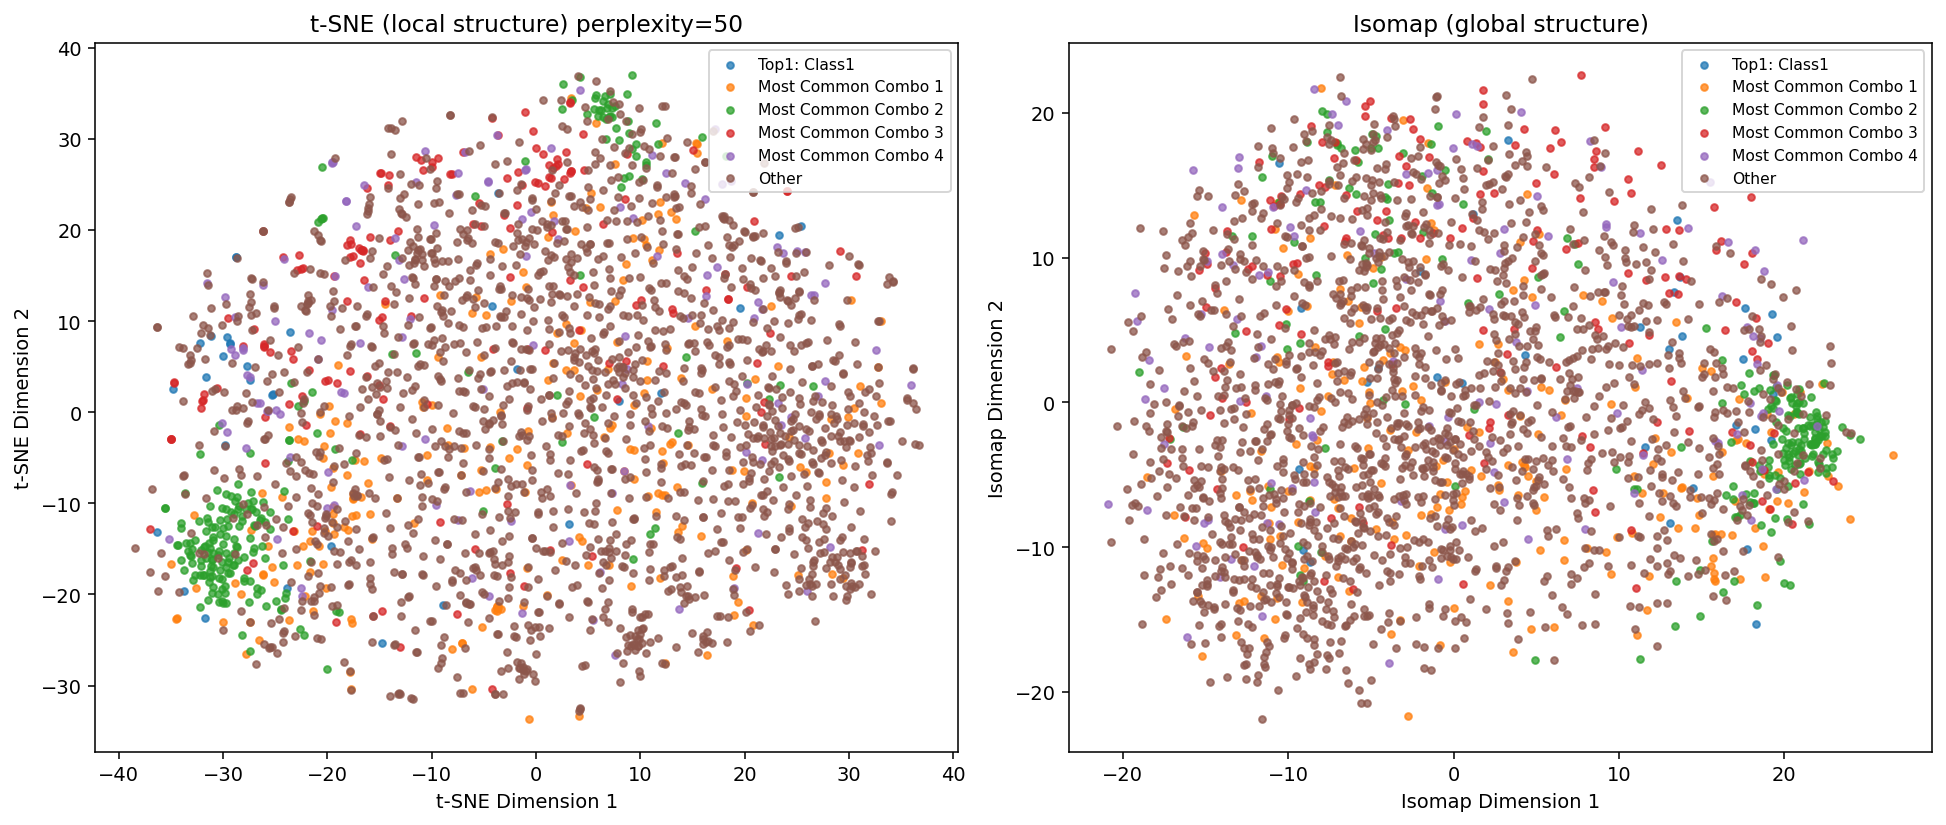

In [58]:


# Compute Isomap embedding (choose preferred n_neighbors)
iso = Isomap(n_components=2, n_neighbors=10)
Z_iso = iso.fit_transform(X_scaled)

# Fixed colors for categories
palette = sns.color_palette("tab10", len(cat_names))

plt.figure(figsize=(14,6))

# t-SNE
plt.subplot(1,2,1)
for c in range(len(cat_names)):
    idx = cat == c
    plt.scatter(Z_final[idx,0], Z_final[idx,1], s=12, alpha=0.75, color=palette[c], label=cat_names[c])
plt.title("t-SNE (local structure) perplexity=50", fontsize=12)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(fontsize=8, loc='upper right')

# Isomap
plt.subplot(1,2,2)
for c in range(len(cat_names)):
    idx = cat == c
    plt.scatter(Z_iso[idx,0], Z_iso[idx,1], s=12, alpha=0.75, color=palette[c], label=cat_names[c])
plt.title("Isomap (global structure)", fontsize=12)
plt.xlabel("Isomap Dimension 1")
plt.ylabel("Isomap Dimension 2")
plt.legend(fontsize=8, loc='upper right')

plt.tight_layout()
plt.show()



### Comparison of t-SNE and Isomap Embeddings

We quantitatively compared the t-SNE and Isomap embeddings using two metrics:

| Method | Trustworthiness (local) | Distance Correlation (global) |
|--------|------------------------|-------------------------------|
| t-SNE  | 0.932                  | 0.408                         |
| Isomap | 0.722                  | 0.474                         |

**Interpretation:**

1. **Local Structure (Trustworthiness):**  
   - t-SNE has a **higher trustworthiness (0.932)** compared to Isomap (0.722).  
   - This means t-SNE preserves **local neighborhoods** better; nearby points in the original high-dimensional space remain close in the 2D embedding.  

2. **Global Structure (Distance Correlation):**  
   - Isomap has a slightly higher distance correlation (0.474) than t-SNE (0.408).  
   - This indicates Isomap preserves the **overall global relationships** between points more accurately, even for points that are far apart in the high-dimensional space.  

**Conclusion:**  
- If the goal is to **understand local clusters and neighborhood structure**, **t-SNE is better**.  
- If the goal is to **preserve global structure** and approximate distances between clusters, **Isomap is better**.  

**Recommendation:**  
- For gene expression data where both local and global structure may be important, it can be useful to **examine both embeddings side by side**:  
  - Use **t-SNE** to explore and separate fine-grained clusters.  
  - Use **Isomap** to understand the broader global structure and relationships between clusters.


### Fundamental Difference Between Isomap and t-SNE

- **Isomap (Global Structure Preservation):**  
  - Isomap is designed to preserve the **global geometry** of the data manifold.  
  - It computes **geodesic distances** (shortest paths along the neighborhood graph) rather than direct Euclidean distances.  
  - This allows Isomap to capture the **overall shape and structure** of the dataset, making it effective for unfolding nonlinear manifolds such as the Swiss roll.  
  - However, it may not always highlight very fine local clusters as clearly as t-SNE.

- **t-SNE (Local Structure Preservation):**  
  - t-SNE focuses on preserving **local neighborhood relationships**.  
  - It ensures that points that are close in high-dimensional space remain close in the 2D embedding.  
  - This makes it very effective at **revealing clusters** and local groupings.  
  - However, the **global distances** between clusters are often distorted, meaning the spacing between groups in the plot is not meaningful.

---

### ✅ Summary
- **Isomap** preserves the **global manifold structure** (big-picture geometry).  
- **t-SNE** preserves the **local neighborhood structure** (small-scale clusters).  
Together, they provide complementary insights: Isomap for understanding overall geometry, and t-SNE for visualizing clusters.
